In [1]:
import TransportMaps as TM
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import TransportMaps.Algorithms.SparsityIdentification as SI
import TransportMaps.Distributions.FrozenDistributions as FD
%matplotlib inline

# Sparsity identification algorithm (SING)

In this example we will show how to use the SING algorithm to identify the Markov random field (MRF) corresponding to a given dataset [[TM5]](aa-references.html#morrison2017). The MRF is encoded with an undirected graph $\mathcal{G} = (V,E)$. Given data from an unknown distribution $\pi$, SING learns the conditional independence by estimating the sparsity of a generalized precison matrix $\Omega = \mathbb{E}_{\pi}[|\partial_{i} \partial_{j} \log \pi|]$. The nonzero entries in $\Omega$ correspond to edges in $E$.

To learn the graph, the SING algorithm performs the following steps:
- Learns a map from samples
- Computes and thresholds $\Omega$ (setting $\Omega_{ij} = 0$ is equivalent to $e_{ij} \notin E$)
- Reorders the variables according to natural ordering
- Recomputes map given a sparse candidate graph
- Iterates...

Here we have an example of 1000 data points generated from a $p = 5$ dimensional multivariate normal with a chain graph structure.

In [2]:
n_samps = 1000
p = 5
chain_dist = FD.ChainGraphGaussianDistribution(p)
data = chain_dist.rvs(n_samps)

In addition to the dataset, the input parameters to SING are (1) **order**: the polynomial order used in the parameterization of the map; (2) **ordering**: the ordering heuristic used to reorder the variables; and (3) **delta**: a tuning parameter used in the thresholding step.

If the data is from a multivariate normal distribution, using linear maps is sufficient. This corresponds to setting the order to 1. If the data is non-Gaussian, we can use a higher order to better characterize the distribution.

To order the variables, available heuristics are ```SI.MinFill()```, ```SI.MinDegree()```, and ```SI.ReverseCholesky()```. We have found the reverse Cholesky to work well in practice.

Increasing delta promotes sparsity in $\Omega$. However, this also has the risk of removing edges in the true graph. Typical values for delta lie in the range $[1,5]$. For more information on the effect of varying delta, see [[TM5]](aa-references.html#morrison2017).

In [3]:
order = 1
ordering = SI.ReverseCholesky()
delta = 2
generalized_precision = SI.SING(data, order, ordering, delta)

Problem inputs:

 dimension =  5 
 number of samples =  1000 
 polynomial order =  1 
 ordering type =  <class 'TransportMaps.Algorithms.SparsityIdentification.NodeOrdering.ReverseCholesky'> 
 delta =  2 


SING Iteration:  1
Active variables:  [[0], [0, 1], [0, 1, 2], [1, 3], [0, 4]] 
  Note variables may be permuted.
Number of edges:  5  out of  10  possible

SING Iteration:  2
Active variables:  [[0], [0, 1], [0, 2], [2, 3], [3, 4]] 
  Note variables may be permuted.
Number of edges:  4  out of  10  possible

SING Iteration:  3
Active variables:  [[0], [0, 1], [0, 2], [2, 3], [3, 4]] 
  Note variables may be permuted.
Number of edges:  4  out of  10  possible

SING has terminated.
Total permutation used:  [3 4 2 1 0]
Recovered graph: 
 [[ 1.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.]
 [ 0.  0.  0.  1.  1.]]


At each iteration, SING prints the list of active variables. These variables indicate the functional dependence of each map component. 

SING returns the generalized precision, as shown below. The non-zeros in this matrix correspond to the edges of the graph. The recovered tri-diagonal structure shows that SING correctly learned the chain graph of the data.

In [6]:
generalized_precision

array([[ 1.39024902,  0.79365777,  0.        ,  0.        ,  0.        ],
       [ 0.79365777,  1.93068186,  0.92532806,  0.        ,  0.        ],
       [ 0.        ,  0.92532806,  2.14197399,  0.88885174,  0.        ],
       [ 0.        ,  0.        ,  0.88885174,  1.97823071,  0.81248244],
       [ 0.        ,  0.        ,  0.        ,  0.81248244,  1.56063022]])

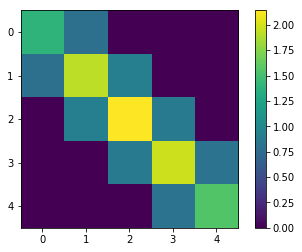

In [7]:
plt.figure()
plt.imshow(generalized_precision)
plt.colorbar()

## Non-Gaussian data

Let's now try a non-Gaussian dataset of $2000$ samples from a $p=6$ dimensional butterfly distribution. This distribution is made up of pairs of random variables. For each pair $(X,Y)$, we take $X \sim \mathcal{N}(0,1)$, $Y = WX$ where $W \sim \mathcal{N}(0,1)$.

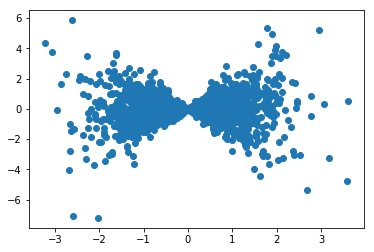

In [43]:
p = 6
n_samps = 2000
butterfly = FD.ButterflyDistribution(p)
data = butterfly.rvs(n_samps)

plt.scatter(data[:,0],data[:,1])

Above is a scatter plot of the first two variables, with a clearly non-Gaussian 2D marginal distribution. Thus, we use order 3 polynomials to capture the non-Gaussian features.

In [52]:
order = 3
ordering = SI.ReverseCholesky()
delta = 3
generalized_precision = SI.SING(data, order, ordering, delta)

Problem inputs:

 dimension =  6 
 number of samples =  2000 
 polynomial order =  3 
 ordering type =  <class 'TransportMaps.Algorithms.SparsityIdentification.NodeOrdering.ReverseCholesky'> 
 delta =  3 


SING Iteration:  1
Active variables:  [[0], [0, 1], [2], [2, 3], [4], [4, 5]] 
  Note variables may be permuted.
Number of edges:  3  out of  15  possible

SING Iteration:  2
Active variables:  [[0], [0, 1], [2], [2, 3], [4], [4, 5]] 
  Note variables may be permuted.
Number of edges:  3  out of  15  possible

SING has terminated.
Total permutation used:  [0 1 2 3 4 5]
Recovered graph: 
 [[ 1.  1.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.]]


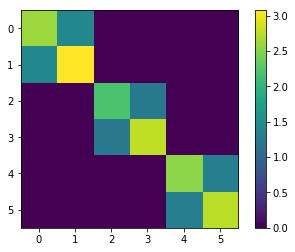

In [53]:
plt.figure()
plt.imshow(generalized_precision)
plt.colorbar()

SING correctly recovers the 2x2 block structure of the generalized precision, showing edges between variable pairs. If we try an order 1 map, we incorrectly recover an approximately diagonal $\Omega$ matrix.

In [57]:
order = 1
delta = 3
generalized_precision = SI.SING(data, order, ordering, delta)

Problem inputs:

 dimension =  6 
 number of samples =  2000 
 polynomial order =  1 
 ordering type =  <class 'TransportMaps.Algorithms.SparsityIdentification.NodeOrdering.ReverseCholesky'> 
 delta =  3 


SING Iteration:  1
Active variables:  [[0], [1], [2], [3], [4], [4, 5]] 
  Note variables may be permuted.
Number of edges:  1  out of  15  possible

SING Iteration:  2
Active variables:  [[0], [1], [2], [3], [4], [4, 5]] 
  Note variables may be permuted.
Number of edges:  1  out of  15  possible

SING has terminated.
Total permutation used:  [0 1 2 3 4 5]
Recovered graph: 
 [[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.]]


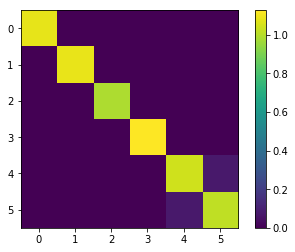

In [58]:
plt.figure()
plt.imshow(generalized_precision)
plt.colorbar()